## PTA harmonic analysis beyond isotropy

We import the necessary packages such as PTAfast and the Wigner-3j symbol python package.

In [1]:
import os # requires *full path*

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # for insets, if needed

import numpy as np
from PTAfast.tensor import Tensor
from PTAfast.vector import Vector
from PTAfast.scalar import ScalarL as SL
from PTAfast.scalar import ScalarT as ST
from PTAfast.hellingsdowns import HellingsDowns as HD

from scipy.special import sph_harm
import py3nj

# setup 3j symbol
def w3j(a1, a2, a3, b1, b2, b3):
    # Check if |b1| > |a1| or |b2| > |a2| or |b3| > |a3|
    if abs(b1) > abs(a1) or abs(b2) > abs(a2) or abs(b3) > abs(a3):
        return 0  # Return zero in the special cases
    else:
        # all arguments doubled in py3nj.wigner3j
        return py3nj.wigner3j(int(a1*2), int(a2*2), int(a3*2), int(b1*2), int(b2*2), int(b3*2))

In this notebook we investigate the correlation for an anisotropic polarized stochastic gravitational wave background. We consider tensor, vector, and scalar gravitational waves. For each GW mode, the important $J_l$'s (not Bessel functions) are written below.

In [2]:
# these are derived in arXiv:2208.12538

def Jls_T(v, lM = 10, fD = 500):
    '''Tensor Jl's for GW speed v with fixed distance fD'''
    gwb_mode = Tensor(lm = lM, v = v, fD = fD)
    jls = np.array([(l, gwb_mode.Jl_T(l)) for l in np.arange(2, gwb_mode.lm + 1)])
    return jls

def Jls_V(v, lM = 10, fD = 500):
    '''Vector Jl's for GW speed v with fixed distance fD'''
    gwb_mode = Vector(lm = lM, v = v, fD = fD)
    jls = np.array([(l, gwb_mode.JV(l)) for l in np.arange(1, gwb_mode.lm + 1)])
    return jls

def Jls_S(v, lM = 10, fD = 500):
    st_mode = ST(lm = lM, v = v, fD = fD)
    sl_mode = SL(lm = lM, v = v, fD = fD)
    mix = (1 - v**2)/np.sqrt(2)
    nn = np.sqrt(32*(np.pi**2)) # normalization to match PTAfast scalar ST at v = 1.0
    jls = np.array([(l, nn*(st_mode.F_ST(l) + mix*sl_mode.F_SL(l))) for l in \
                    np.arange(0, st_mode.lm + 1)])
    return jls

### Tensor GW correlations

We start with tensor GWs, which lead to the Hellings-Downs curve in the isotropic case. The function below sets up the calculation for the correlation associated with Stokes parameters $I$ (intensity), $V$ (anisotropy), $Q$ (polarization), $U$ (polarization).

In [3]:
def gabIVQU_T(zeta, v, l, m, lM = 10, fD = 1000):
    '''Returns tensor correlation for Stokes I and V'''
    jls = Jls_T(v = v, lM = lM, fD = fD)
    lls = list(jls[:, 0].real) # the indices
    
    dgabdx_I = []
    dgabdx_V = []
    dgabdx_QpiU = []
    dgabdx_QmiU = []
    # terms
    for l1 in np.arange(2, lM + 1): # sum starts at 2 for tensor modes
        for l2 in np.arange(2, lM + 1):
            
            i1 = lls.index(l1) # indices of l1 and l2 in jls
            i2 = lls.index(l2)
            
            # I and V differs in sign only in f1 -> (1 \pm (-1)^{l + l1 + l2})
            # Q \pm i U has same f1 but different f2
            f1_I = ((-1)**m)*((2*l1 + 1)/(4*np.pi))*(1 + (-1)**(l + l1 + l2))*np.sqrt((2*l + 1)*(2*l2 + 1))
            f1_V = ((-1)**m)*((2*l1 + 1)/(4*np.pi))*(1 - (-1)**(l + l1 + l2))*np.sqrt((2*l + 1)*(2*l2 + 1))
            f1_QU = ((-1)**m)*((2*l1 + 1)/(4*np.pi))*np.sqrt((2*l + 1)*(2*l2 + 1))
            
            f2 = w3j(l, l1, l2, 0, -2, 2)*w3j(l, l1, l2, m, 0, -m)
            f2_QpiU = w3j(l, l1, l2, -4, 2, 2)*w3j(l, l1, l2, m, 0, -m)
            f2_QmiU = w3j(l, l1, l2, 4, -2, -2)*w3j(l, l1, l2, m, 0, -m)
             
            f3 = jls[:, 1][i1]*np.conj(jls[:, 1][i2])
            
            if abs(m) <= l2:
                f4 = sph_harm(m, l2, 0, zeta)
            elif abs(m) > l2:
                f4 = 0
            
            dgabdx_I.append(f1_I*f2*f3*f4)
            dgabdx_V.append(f1_V*f2*f3*f4)
            dgabdx_QpiU.append(f1_QU*f2_QpiU*f3*f4)
            dgabdx_QmiU.append(f1_QU*f2_QmiU*f3*f4)
     
    gab_dict = {'I': sum(dgabdx_I), 'V': sum(dgabdx_V), \
                'QpiU': sum(dgabdx_QpiU), 'QmiU': sum(dgabdx_QmiU)} 
    return gab_dict

Having this, we evalaute the correlation for tensor GWs with speeds $v = 1, 0.5, 0.1$ with pulsars at a fixed distance of $fD = 500$.

In [4]:
ztarr = np.linspace(0, np.pi, 200 + 1)

# correlations for v = 1.0
gab00_v1 = gabIVQU_T(ztarr, v = 1.0, l = 0, m = 0, lM = 50) # isotropic/ HD curve

gab10_v1 = gabIVQU_T(ztarr, v = 1.0, l = 1, m = 0, lM = 50) # anisotropy
gab11_v1 = gabIVQU_T(ztarr, v = 1.0, l = 1, m = 1, lM = 50)

gab20_v1 = gabIVQU_T(ztarr, v = 1.0, l = 2, m = 0, lM = 50)
gab21_v1 = gabIVQU_T(ztarr, v = 1.0, l = 2, m = 1, lM = 50)
gab22_v1 = gabIVQU_T(ztarr, v = 1.0, l = 2, m = 2, lM = 50)

gab30_v1 = gabIVQU_T(ztarr, v = 1.0, l = 3, m = 0, lM = 50)
gab31_v1 = gabIVQU_T(ztarr, v = 1.0, l = 3, m = 1, lM = 50)
gab32_v1 = gabIVQU_T(ztarr, v = 1.0, l = 3, m = 2, lM = 50)
gab33_v1 = gabIVQU_T(ztarr, v = 1.0, l = 3, m = 3, lM = 50)

gab40_v1 = gabIVQU_T(ztarr, v = 1.0, l = 4, m = 0, lM = 50) # polarization
gab41_v1 = gabIVQU_T(ztarr, v = 1.0, l = 4, m = 1, lM = 50)
gab42_v1 = gabIVQU_T(ztarr, v = 1.0, l = 4, m = 2, lM = 50)
gab43_v1 = gabIVQU_T(ztarr, v = 1.0, l = 4, m = 3, lM = 50)
gab44_v1 = gabIVQU_T(ztarr, v = 1.0, l = 4, m = 4, lM = 50)


# repeat all for v = 0.5
gab00_v2 = gabIVQU_T(ztarr, v = 0.5, l = 0, m = 0, lM = 50) # isotropic

gab10_v2 = gabIVQU_T(ztarr, v = 0.5, l = 1, m = 0, lM = 50) # anisotropy
gab11_v2 = gabIVQU_T(ztarr, v = 0.5, l = 1, m = 1, lM = 50)

gab20_v2 = gabIVQU_T(ztarr, v = 0.5, l = 2, m = 0, lM = 50)
gab21_v2 = gabIVQU_T(ztarr, v = 0.5, l = 2, m = 1, lM = 50)
gab22_v2 = gabIVQU_T(ztarr, v = 0.5, l = 2, m = 2, lM = 50)

gab30_v2 = gabIVQU_T(ztarr, v = 0.5, l = 3, m = 0, lM = 50)
gab31_v2 = gabIVQU_T(ztarr, v = 0.5, l = 3, m = 1, lM = 50)
gab32_v2 = gabIVQU_T(ztarr, v = 0.5, l = 3, m = 2, lM = 50)
gab33_v2 = gabIVQU_T(ztarr, v = 0.5, l = 3, m = 3, lM = 50)

gab40_v2 = gabIVQU_T(ztarr, v = 0.5, l = 4, m = 0, lM = 50) # polarization
gab41_v2 = gabIVQU_T(ztarr, v = 0.5, l = 4, m = 1, lM = 50)
gab42_v2 = gabIVQU_T(ztarr, v = 0.5, l = 4, m = 2, lM = 50)
gab43_v2 = gabIVQU_T(ztarr, v = 0.5, l = 4, m = 3, lM = 50)
gab44_v2 = gabIVQU_T(ztarr, v = 0.5, l = 4, m = 4, lM = 50)


# repeat all for v = 0.1
gab00_v3 = gabIVQU_T(ztarr, v = 0.1, l = 0, m = 0, lM = 50) # isotropic

gab10_v3 = gabIVQU_T(ztarr, v = 0.1, l = 1, m = 0, lM = 50) # anisotropy
gab11_v3 = gabIVQU_T(ztarr, v = 0.1, l = 1, m = 1, lM = 50)

gab20_v3 = gabIVQU_T(ztarr, v = 0.1, l = 2, m = 0, lM = 50)
gab21_v3 = gabIVQU_T(ztarr, v = 0.1, l = 2, m = 1, lM = 50)
gab22_v3 = gabIVQU_T(ztarr, v = 0.1, l = 2, m = 2, lM = 50)

gab30_v3 = gabIVQU_T(ztarr, v = 0.1, l = 3, m = 0, lM = 50)
gab31_v3 = gabIVQU_T(ztarr, v = 0.1, l = 3, m = 1, lM = 50)
gab32_v3 = gabIVQU_T(ztarr, v = 0.1, l = 3, m = 2, lM = 50)
gab33_v3 = gabIVQU_T(ztarr, v = 0.1, l = 3, m = 3, lM = 50)

gab40_v3 = gabIVQU_T(ztarr, v = 0.1, l = 4, m = 0, lM = 50) # polarization
gab41_v3 = gabIVQU_T(ztarr, v = 0.1, l = 4, m = 1, lM = 50)
gab42_v3 = gabIVQU_T(ztarr, v = 0.1, l = 4, m = 2, lM = 50)
gab43_v3 = gabIVQU_T(ztarr, v = 0.1, l = 4, m = 3, lM = 50)
gab44_v3 = gabIVQU_T(ztarr, v = 0.1, l = 4, m = 4, lM = 50)

So here is the plot of the leading isotropic component.

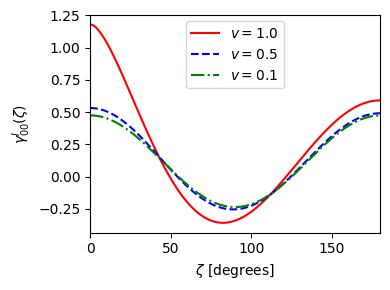

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(ztarr*180/np.pi, gab00_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax.plot(ztarr*180/np.pi, gab00_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax.plot(ztarr*180/np.pi, gab00_v3['I'].real, 'g-.', label = r'$v = 0.1$')

ax.set_ylabel(r'$\gamma_{00}^I(\zeta)$')
ax.legend(loc = 'upper center')
ax.set_xlabel(r'$\zeta$ [degrees]')
ax.set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
fig.tight_layout()
plt.show()

However, this is nothing new. The red line is the HD curve. We go to the higher moments for new effects.

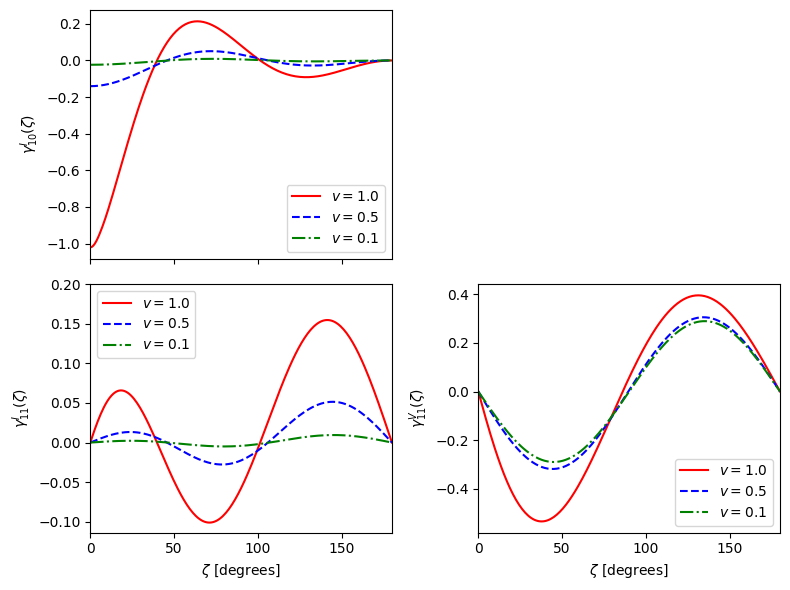

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Hide x-axis labels for all but the bottom plots
for xx in ax[:-1, 0]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 1]:
    plt.setp(xx.get_xticklabels(), visible=False)

ax[0,0].plot(ztarr*180/np.pi, gab10_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[0,0].plot(ztarr*180/np.pi, gab10_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[0,0].plot(ztarr*180/np.pi, gab10_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[0,0].set_ylabel(r'$\gamma_{10}^I(\zeta)$')
ax[0,0].legend(loc = 'lower right')
ax[0,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[0,1].remove()

ax[1,0].plot(ztarr*180/np.pi, gab11_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[1,0].plot(ztarr*180/np.pi, gab11_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[1,0].plot(ztarr*180/np.pi, gab11_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[1,0].set_ylabel(r'$\gamma_{11}^I(\zeta)$')
ax[1,0].legend(loc = 'upper left')
ax[1,0].set_xlabel(r'$\zeta$ [degrees]')
ax[1,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
ax[1,0].set_ylim(top = 0.20)

ax[1,1].plot(ztarr*180/np.pi, gab11_v1['V'].real, 'r-', label = r'$v = 1.0$')
ax[1,1].plot(ztarr*180/np.pi, gab11_v2['V'].real, 'b--', label = r'$v = 0.5$')
ax[1,1].plot(ztarr*180/np.pi, gab11_v3['V'].real, 'g-.', label = r'$v = 0.1$')
ax[1,1].set_ylabel(r'$\gamma_{11}^V(\zeta)$')
ax[1,1].legend(loc = 'lower right')
ax[1,1].set_xlabel(r'$\zeta$ [degrees]')
ax[1,1].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

fig.tight_layout()
plt.show()

Take note at this point, we haven't checked yet the $Q$ and $U$ Stokes parameters. These are zero until we go to $l = 4$. So we'll get up there. Meanwhile, here are the plots for $l = 2$.

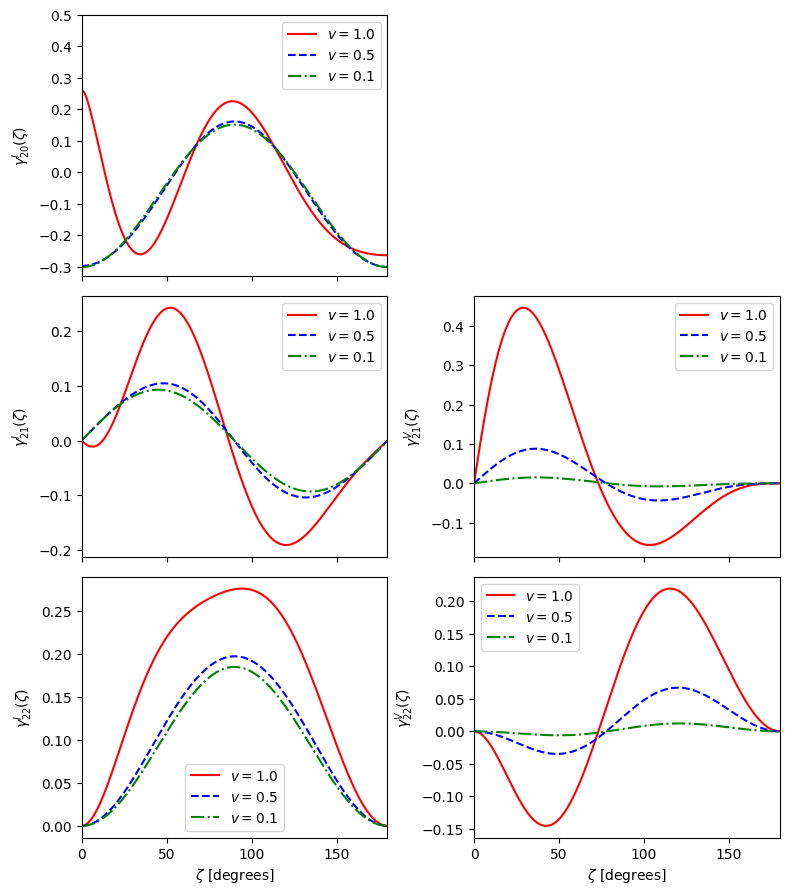

In [7]:
fig, ax = plt.subplots(3, 2, figsize = (8,9))
# Hide x-axis labels for all but the bottom plots
for xx in ax[:-1, 0]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 1]:
    plt.setp(xx.get_xticklabels(), visible=False)

ax[0,0].plot(ztarr*180/np.pi, gab20_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[0,0].plot(ztarr*180/np.pi, gab20_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[0,0].plot(ztarr*180/np.pi, gab20_v3['I'].real, 'g-.', label = r'$v = 0.1$')

ax[0,0].set_ylabel(r'$\gamma_{20}^I(\zeta)$')
ax[0,0].legend(loc = 'upper right')
ax[0,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
ax[0,0].set_ylim(top = 0.5)

ax[0,1].remove()

# l = 2, m = 1
ax[1,0].plot(ztarr*180/np.pi, gab21_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[1,0].plot(ztarr*180/np.pi, gab21_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[1,0].plot(ztarr*180/np.pi, gab21_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[1,0].set_ylabel(r'$\gamma_{21}^I(\zeta)$')
ax[1,0].legend(loc = 'upper right')
ax[1,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[1,1].plot(ztarr*180/np.pi, gab21_v1['V'].real, 'r-', label = r'$v = 1.0$')
ax[1,1].plot(ztarr*180/np.pi, gab21_v2['V'].real, 'b--', label = r'$v = 0.5$')
ax[1,1].plot(ztarr*180/np.pi, gab21_v3['V'].real, 'g-.', label = r'$v = 0.1$')
ax[1,1].set_ylabel(r'$\gamma_{21}^V(\zeta)$')
ax[1,1].legend(loc = 'upper right')
ax[1,1].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

# l = 2, m = 2
ax[2,0].plot(ztarr*180/np.pi, gab22_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[2,0].plot(ztarr*180/np.pi, gab22_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[2,0].plot(ztarr*180/np.pi, gab22_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[2,0].set_ylabel(r'$\gamma_{22}^I(\zeta)$')
ax[2,0].legend(loc = 'lower center')
ax[2,0].set_xlabel(r'$\zeta$ [degrees]')
ax[2,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[2,1].plot(ztarr*180/np.pi, gab22_v1['V'].real, 'r-', label = r'$v = 1.0$')
ax[2,1].plot(ztarr*180/np.pi, gab22_v2['V'].real, 'b--', label = r'$v = 0.5$')
ax[2,1].plot(ztarr*180/np.pi, gab22_v3['V'].real, 'g-.', label = r'$v = 0.1$')
ax[2,1].set_ylabel(r'$\gamma_{22}^V(\zeta)$')
ax[2,1].legend(loc = 'upper left')
ax[2,1].set_xlabel(r'$\zeta$ [degrees]')
ax[2,1].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

fig.tight_layout()
plt.show()

For $l = 3$, we have the following plots for the correlation in the next line.

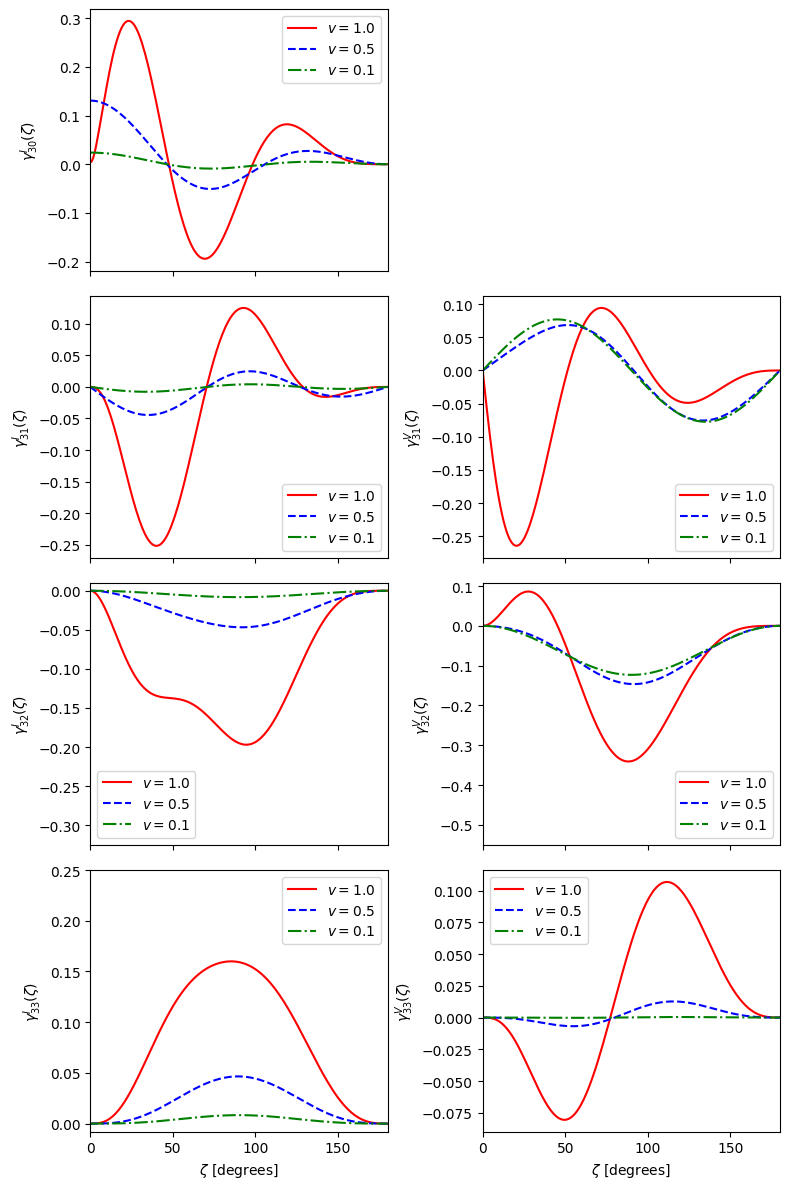

In [8]:
fig, ax = plt.subplots(4, 2, figsize = (8,12))
for xx in ax[:-1, 0]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 1]:
    plt.setp(xx.get_xticklabels(), visible=False)
    
ax[0,1].remove()

# l = 3, m = 0
ax[0,0].plot(ztarr*180/np.pi, gab30_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[0,0].plot(ztarr*180/np.pi, gab30_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[0,0].plot(ztarr*180/np.pi, gab30_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[0,0].set_ylabel(r'$\gamma_{30}^I(\zeta)$')
ax[0,0].legend(loc = 'upper right')
ax[0,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

# l = 3, m = 1
ax[1,0].plot(ztarr*180/np.pi, gab31_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[1,0].plot(ztarr*180/np.pi, gab31_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[1,0].plot(ztarr*180/np.pi, gab31_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[1,0].set_ylabel(r'$\gamma_{31}^I(\zeta)$')
ax[1,0].legend(loc = 'lower right')
ax[1,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[1,1].plot(ztarr*180/np.pi, gab31_v1['V'].real, 'r-', label = r'$v = 1.0$')
ax[1,1].plot(ztarr*180/np.pi, gab31_v2['V'].real, 'b--', label = r'$v = 0.5$')
ax[1,1].plot(ztarr*180/np.pi, gab31_v3['V'].real, 'g-.', label = r'$v = 0.1$')
ax[1,1].set_ylabel(r'$\gamma_{31}^V(\zeta)$')
ax[1,1].legend(loc = 'lower right')
ax[1,1].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

# l = 3, m = 2
ax[2,0].plot(ztarr*180/np.pi, gab32_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[2,0].plot(ztarr*180/np.pi, gab32_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[2,0].plot(ztarr*180/np.pi, gab32_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[2,0].set_ylabel(r'$\gamma_{32}^I(\zeta)$')
ax[2,0].legend(loc = 'lower left')
ax[2,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
ax[2,0].set_ylim(bottom = -0.325)

ax[2,1].plot(ztarr*180/np.pi, gab32_v1['V'].real, 'r-', label = r'$v = 1.0$')
ax[2,1].plot(ztarr*180/np.pi, gab32_v2['V'].real, 'b--', label = r'$v = 0.5$')
ax[2,1].plot(ztarr*180/np.pi, gab32_v3['V'].real, 'g-.', label = r'$v = 0.1$')
ax[2,1].set_ylabel(r'$\gamma_{32}^V(\zeta)$')
ax[2,1].legend(loc = 'lower right')
ax[2,1].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
ax[2,1].set_ylim(bottom = -0.55)

# l = 3, m = 3
ax[3,0].plot(ztarr*180/np.pi, gab33_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[3,0].plot(ztarr*180/np.pi, gab33_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[3,0].plot(ztarr*180/np.pi, gab33_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[3,0].set_ylabel(r'$\gamma_{33}^I(\zeta)$')
ax[3,0].legend(loc = 'upper right')
ax[3,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
ax[3,0].set_xlabel(r'$\zeta$ [degrees]')
ax[3,0].set_ylim(top = 0.25)

ax[3,1].plot(ztarr*180/np.pi, gab33_v1['V'].real, 'r-', label = r'$v = 1.0$')
ax[3,1].plot(ztarr*180/np.pi, gab33_v2['V'].real, 'b--', label = r'$v = 0.5$')
ax[3,1].plot(ztarr*180/np.pi, gab33_v3['V'].real, 'g-.', label = r'$v = 0.1$')
ax[3,1].set_ylabel(r'$\gamma_{33}^V(\zeta)$')
ax[3,1].legend(loc = 'upper left')
ax[3,1].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
ax[3,1].set_xlabel(r'$\zeta$ [degrees]')

fig.tight_layout()
plt.show()

Finally we reach $l = 4$ where we observe nonzero $Q$ and $U$ Stokes parameters, indicating signal from polarization. These are shown below for $m \leq 4$.

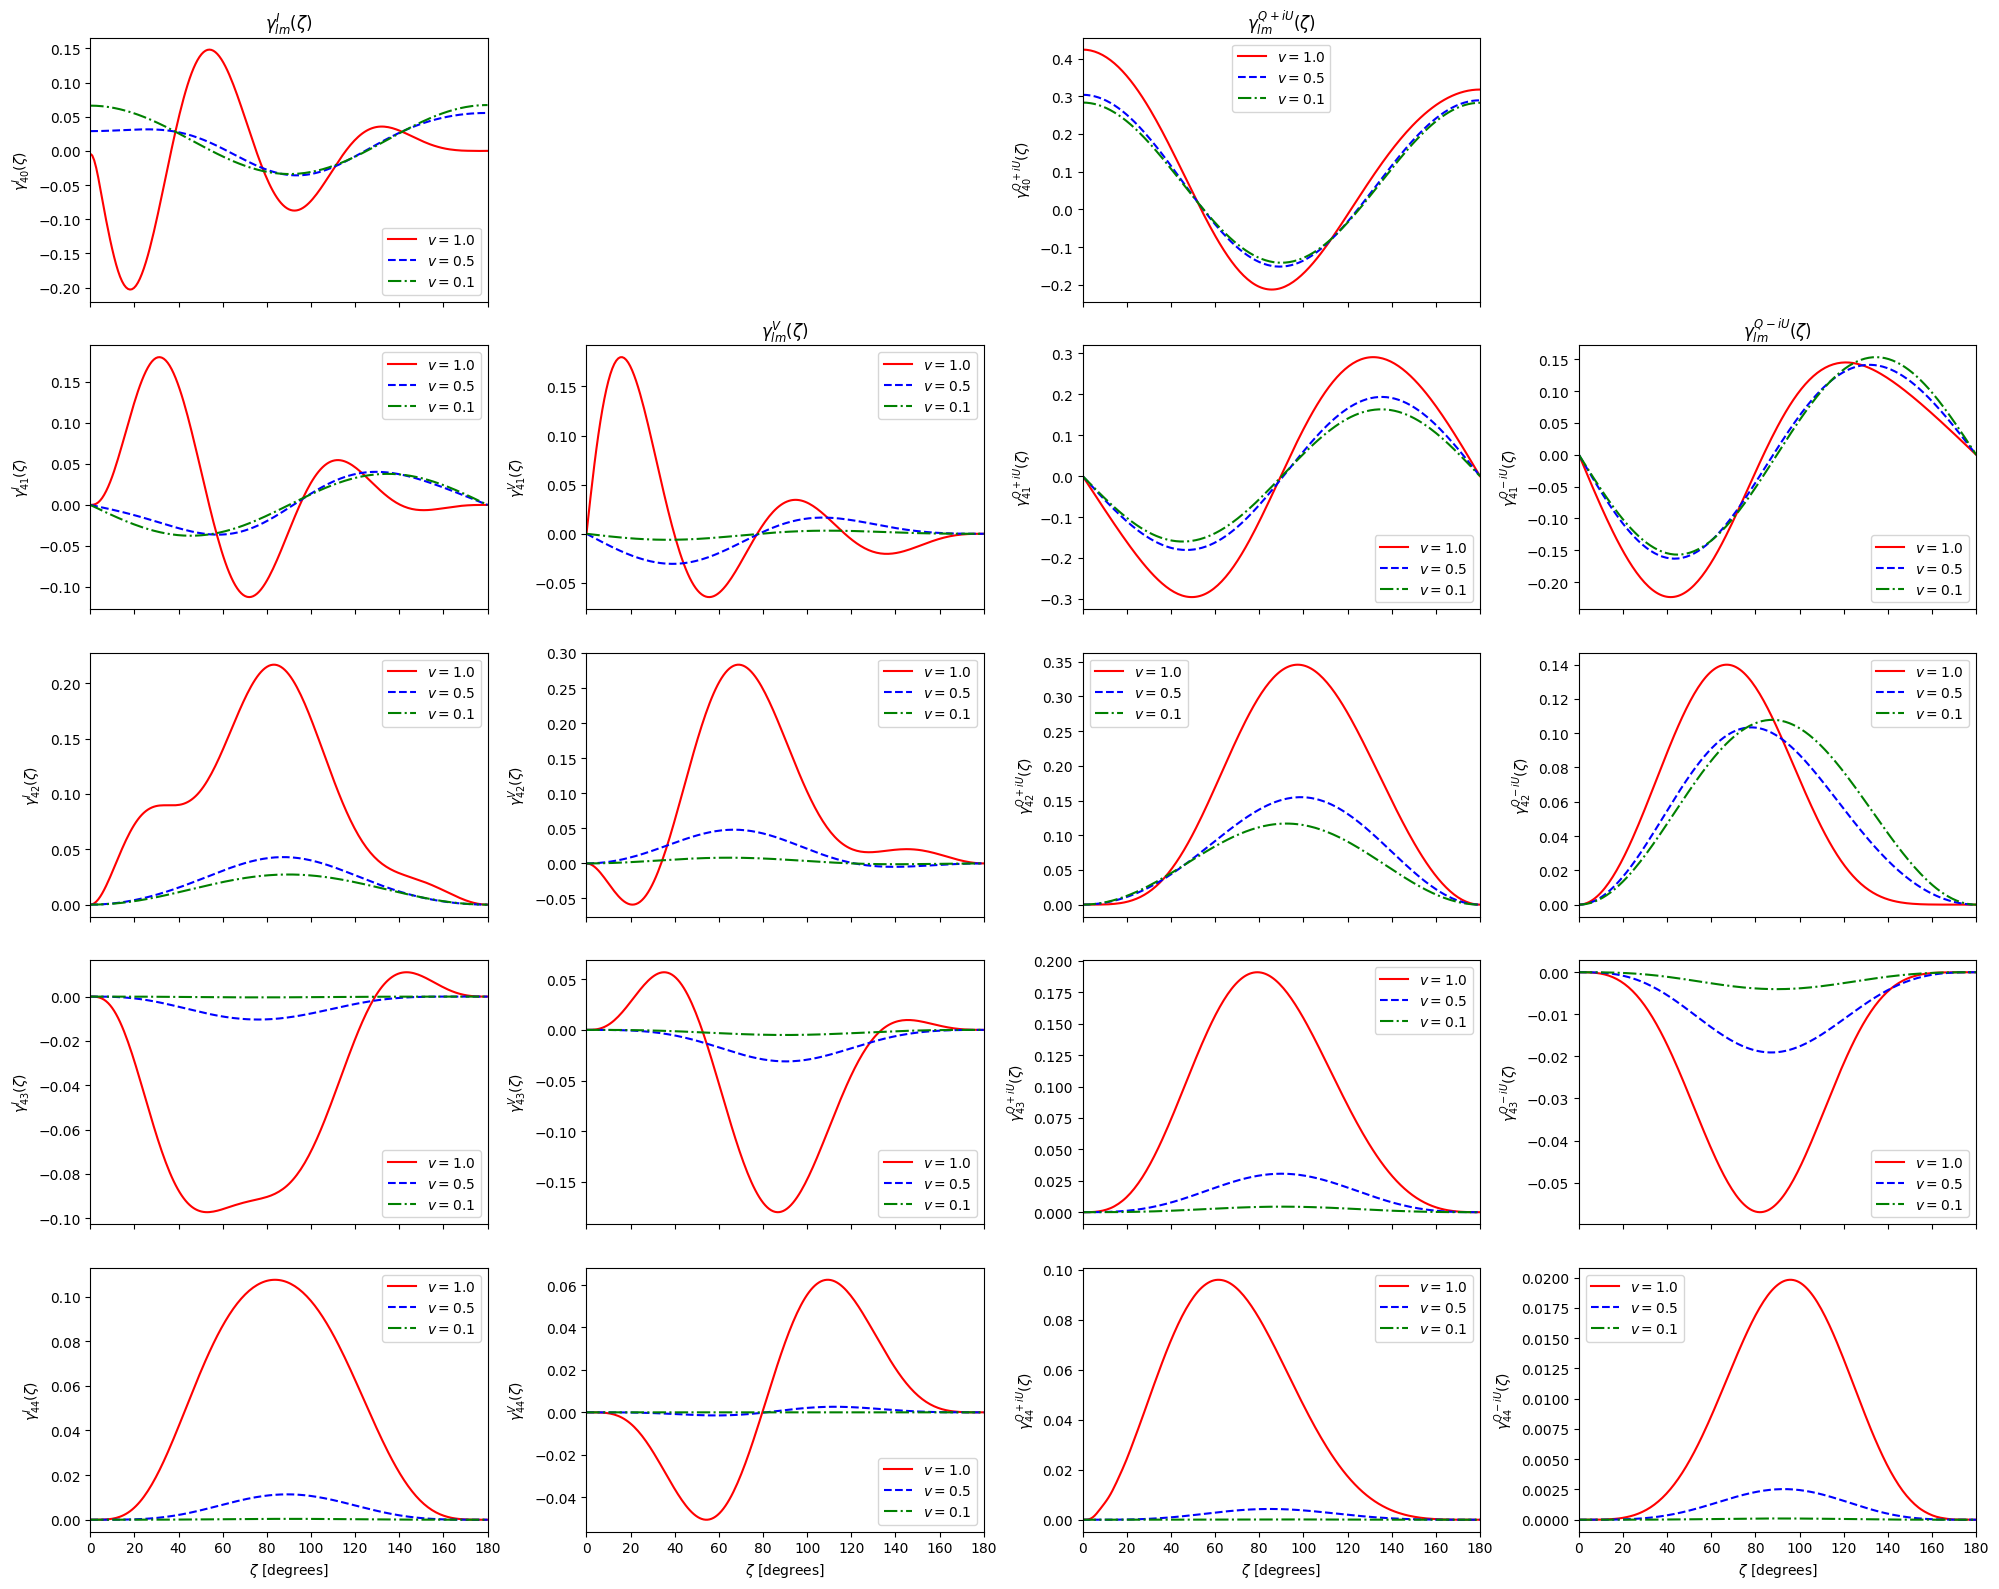

In [9]:
def plotIVQU(l, m, zzzz, axs, gab, labels, llocs):
    '''helpful plotting function'''
    gab0 = gab[0]
    gab1 = gab[1]
    gab2 = gab[2]
    
    stokes = ['I', 'V', 'QpiU', 'QmiU']
    lmstr = str(int(l)) + str(int(m))
    ylabels = [r'$\gamma_{' + lmstr + '}^I(\zeta)$', \
               r'$\gamma_{' + lmstr + '}^V(\zeta)$', \
               r'$\gamma_{' + lmstr + '}^{Q + iU}(\zeta)$', \
               r'$\gamma_{' + lmstr + '}^{Q - iU}(\zeta)$']
    
    for sss in stokes:
        ii = stokes.index(sss)
        axs[ii].plot(zzzz*180/np.pi, gab0[sss].real, 'r-', label = labels[0])
        axs[ii].plot(zzzz*180/np.pi, gab1[sss].real, 'b--', label = labels[1])
        axs[ii].plot(zzzz*180/np.pi, gab2[sss].real, 'g-.', label = labels[2])
        axs[ii].set_ylabel(ylabels[ii])
        axs[ii].legend(loc = llocs[ii])
        axs[ii].set_xlim(min(zzzz*180/np.pi), max(zzzz*180/np.pi))
        

fig, ax = plt.subplots(5, 4, figsize = (20,16))
for xx in ax[:-1, 0]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 1]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 2]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 3]:
    plt.setp(xx.get_xticklabels(), visible=False)
    
ax[0,1].remove()
ax[0,3].remove()

# l = 4, m = 0
ax[0,0].plot(ztarr*180/np.pi, gab40_v1['I'].real, 'r-', label = r'$v = 1.0$')
ax[0,0].plot(ztarr*180/np.pi, gab40_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[0,0].plot(ztarr*180/np.pi, gab40_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[0,0].set_ylabel(r'$\gamma_{40}^I(\zeta)$')
ax[0,0].legend(loc = 'lower right')
ax[0,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[0,2].plot(ztarr*180/np.pi, gab40_v1['QpiU'].real, 'r-', label = r'$v = 1.0$')
ax[0,2].plot(ztarr*180/np.pi, gab40_v2['QpiU'].real, 'b--', label = r'$v = 0.5$')
ax[0,2].plot(ztarr*180/np.pi, gab40_v3['QpiU'].real, 'g-.', label = r'$v = 0.1$')
ax[0,2].set_ylabel(r'$\gamma_{40}^{Q + i U}(\zeta)$')
ax[0,2].legend(loc = 'upper center')
ax[0,2].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[4,0].set_xlabel(r'$\zeta$ [degrees]')
ax[4,1].set_xlabel(r'$\zeta$ [degrees]')
ax[4,2].set_xlabel(r'$\zeta$ [degrees]')
ax[4,3].set_xlabel(r'$\zeta$ [degrees]')

ax[0,0].set_title(r'$\gamma_{lm}^I(\zeta)$')
ax[1,1].set_title(r'$\gamma_{lm}^V(\zeta)$')
ax[0,2].set_title(r'$\gamma_{lm}^{Q + iU}(\zeta)$')
ax[1,3].set_title(r'$\gamma_{lm}^{Q - iU}(\zeta)$')

plotIVQU(l = 4, m = 1, zzzz = ztarr, axs = [ax[1,0], ax[1,1], ax[1,2], ax[1,3]], \
         gab = [gab41_v1, gab41_v2, gab41_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.1$'], \
         llocs = ['upper right', 'upper right', 'lower right', 'lower right'])

plotIVQU(l = 4, m = 2, zzzz = ztarr, axs = [ax[2,0], ax[2,1], ax[2,2], ax[2,3]], \
         gab = [gab42_v1, gab42_v2, gab42_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.1$'], \
         llocs = ['upper right', 'upper right', 'upper left', 'upper right'])

plotIVQU(l = 4, m = 3, zzzz = ztarr, axs = [ax[3,0], ax[3,1], ax[3,2], ax[3,3]], \
         gab = [gab43_v1, gab43_v2, gab43_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.1$'], \
         llocs = ['lower right', 'lower right', 'upper right', 'lower right'])

plotIVQU(l = 4, m = 4, zzzz = ztarr, axs = [ax[4,0], ax[4,1], ax[4,2], ax[4,3]], \
         gab = [gab44_v1, gab44_v2, gab44_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.1$'], \
         llocs = ['upper right', 'lower right', 'upper right', 'upper left'])

fig.tight_layout()
plt.show()

This is as far as we'll go for tensors. We proceed with the vector and scalar GWs, next.

### Vector GWs

The correlations for an anisotropic polarized SGWB filled with vectors modes is given below.

In [10]:
def gabIVQU_V(zeta, v, l, m, lM = 10, fD = 1000):
    '''Returns tensor correlation for Stokes I and V'''
    jls = Jls_V(v = v, lM = lM, fD = fD)
    lls = list(jls[:, 0].real) # the indices
    
    dgabdx_I = []
    dgabdx_V = []
    dgabdx_QpiU = []
    dgabdx_QmiU = []
    # terms
    for l1 in np.arange(1, lM + 1): # sum starts at 1 for vector modes
        for l2 in np.arange(1, lM + 1):
            
            i1 = lls.index(l1) # indices of l1 and l2 in jls
            i2 = lls.index(l2)
            
            # I and V differs in sign only in f1 -> (1 \pm (-1)^{l + l1 + l2})
            # Q \pm i U has same f1 but different f2
            f1_I = ((-1)**(1 + m))*((2*l1 + 1)/(4*np.pi))*(1 + (-1)**(l + l1 + l2))*np.sqrt((2*l + 1)*(2*l2 + 1))
            f1_V = ((-1)**(1 + m))*((2*l1 + 1)/(4*np.pi))*(1 - (-1)**(l + l1 + l2))*np.sqrt((2*l + 1)*(2*l2 + 1))
            f1_QU = ((-1)**m)*((2*l1 + 1)/(4*np.pi))*np.sqrt((2*l + 1)*(2*l2 + 1))
            
            f2 = w3j(l, l1, l2, 0, -1, 1)*w3j(l, l1, l2, m, 0, -m)
            f2_QpiU = w3j(l, l1, l2, -2, 1, 1)*w3j(l, l1, l2, m, 0, -m)
            f2_QmiU = w3j(l, l1, l2, 2, -1, -1)*w3j(l, l1, l2, m, 0, -m)
             
            f3 = jls[:, 1][i1]*np.conj(jls[:, 1][i2])
            
            if abs(m) <= l2:
                f4 = sph_harm(m, l2, 0, zeta)
            elif abs(m) > l2:
                f4 = 0
            
            dgabdx_I.append(f1_I*f2*f3*f4)
            dgabdx_V.append(f1_V*f2*f3*f4)
            dgabdx_QpiU.append(f1_QU*f2_QpiU*f3*f4)
            dgabdx_QmiU.append(f1_QU*f2_QmiU*f3*f4)
     
    gab_dict = {'I': sum(dgabdx_I), 'V': sum(dgabdx_V), \
                'QpiU': sum(dgabdx_QpiU), 'QmiU': sum(dgabdx_QmiU)} 
    return gab_dict

We test that the output agrees with PTAfast in the isotropic case $l = m = 0$.

/home/rbernardo/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rbernardo/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


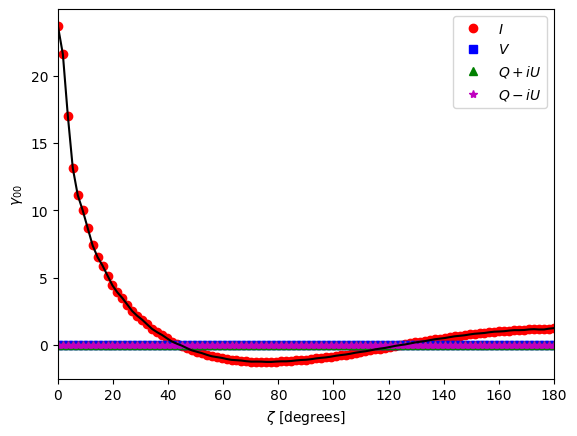

In [11]:
ztarr = np.linspace(0, np.pi, 100 + 1)

# correlations for v = 1.0
gabV00_v1 = gabIVQU_V(ztarr, v = 1.0, l = 0, m = 0, lM = 50)
gabV00_v1_ptafast = Vector(lm = 50, v = 1.0, fD = 1000).get_gab(ztarr)

plt.plot(ztarr*180/np.pi, gabV00_v1['I'], 'ro', label = r'$I$')
plt.plot(ztarr*180/np.pi, gabV00_v1['V'], 'bs', label = r'$V$')
plt.plot(ztarr*180/np.pi, gabV00_v1['QpiU'], 'g^', label = r'$Q + iU$')
plt.plot(ztarr*180/np.pi, gabV00_v1['QmiU'], 'm*', label = r'$Q - iU$')

plt.plot(ztarr*180/np.pi, gabV00_v1_ptafast, 'k-') # isotropic SGWB from PTAfast_v0

plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$\gamma_{00}$')
plt.xlim(0, 180)
plt.legend()
plt.show()

This looks reasonable. We now proceed with the higher moments of the correlation, as we did with the tensor case. We run for several cases in the following line.

In [12]:
ztarr = np.linspace(0, np.pi, 50 + 1)

# correlations for v = 1.0
gabV00_v1 = gabIVQU_V(ztarr, v = 0.9, l = 0, m = 0, lM = 50) # isotropic

gabV10_v1 = gabIVQU_V(ztarr, v = 0.9, l = 1, m = 0, lM = 50) # anisotropy
gabV11_v1 = gabIVQU_V(ztarr, v = 0.9, l = 1, m = 1, lM = 50)

gabV20_v1 = gabIVQU_V(ztarr, v = 0.9, l = 2, m = 0, lM = 50)
gabV21_v1 = gabIVQU_V(ztarr, v = 0.9, l = 2, m = 1, lM = 50)
gabV22_v1 = gabIVQU_V(ztarr, v = 0.9, l = 2, m = 2, lM = 50)


# repeat all for v = 0.5
gabV00_v2 = gabIVQU_V(ztarr, v = 0.5, l = 0, m = 0, lM = 50) # isotropic

gabV10_v2 = gabIVQU_V(ztarr, v = 0.5, l = 1, m = 0, lM = 50) # anisotropy
gabV11_v2 = gabIVQU_V(ztarr, v = 0.5, l = 1, m = 1, lM = 50)

gabV20_v2 = gabIVQU_V(ztarr, v = 0.5, l = 2, m = 0, lM = 50)
gabV21_v2 = gabIVQU_V(ztarr, v = 0.5, l = 2, m = 1, lM = 50)
gabV22_v2 = gabIVQU_V(ztarr, v = 0.5, l = 2, m = 2, lM = 50)


# repeat all for v = 0.1
gabV00_v3 = gabIVQU_V(ztarr, v = 0.1, l = 0, m = 0, lM = 50) # isotropic

gabV10_v3 = gabIVQU_V(ztarr, v = 0.1, l = 1, m = 0, lM = 50) # anisotropy
gabV11_v3 = gabIVQU_V(ztarr, v = 0.1, l = 1, m = 1, lM = 50)

gabV20_v3 = gabIVQU_V(ztarr, v = 0.1, l = 2, m = 0, lM = 50)
gabV21_v3 = gabIVQU_V(ztarr, v = 0.1, l = 2, m = 1, lM = 50)
gabV22_v3 = gabIVQU_V(ztarr, v = 0.1, l = 2, m = 2, lM = 50)

Note that this time we do only the calculations up to $l = 2$ where nontrivial correlations for $Q$ and $U$ appear.

The isotropic correlation is shown below.

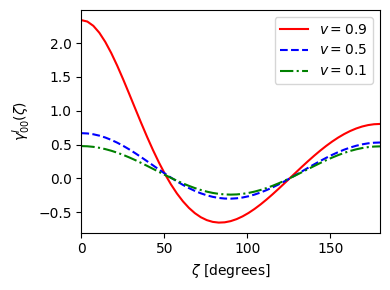

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(ztarr*180/np.pi, gabV00_v1['I'].real, 'r-', label = r'$v = 0.9$')
ax.plot(ztarr*180/np.pi, gabV00_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax.plot(ztarr*180/np.pi, gabV00_v3['I'].real, 'g-.', label = r'$v = 0.1$')

ax.set_ylabel(r'$\gamma_{00}^I(\zeta)$')
ax.legend(loc = 'upper right')
ax.set_xlabel(r'$\zeta$ [degrees]')
ax.set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
fig.tight_layout()
plt.show()

Next line shows the correlation for $l = 1$. At this point, $Q$ and $U$ remain trivial but there is already a nonvanishing $V$-component for $m = 1$.

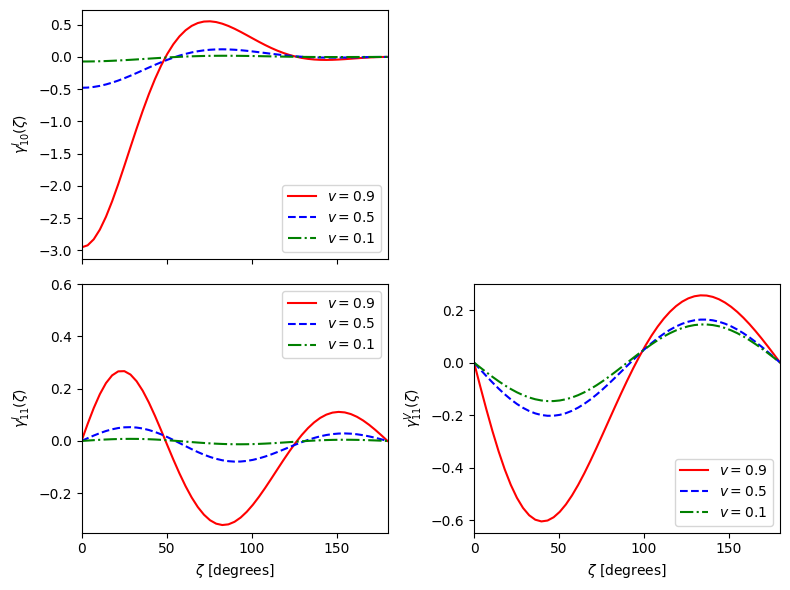

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Hide x-axis labels for all but the bottom plots
for xx in ax[:-1, 0]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 1]:
    plt.setp(xx.get_xticklabels(), visible=False)

ax[0,0].plot(ztarr*180/np.pi, gabV10_v1['I'].real, 'r-', label = r'$v = 0.9$')
ax[0,0].plot(ztarr*180/np.pi, gabV10_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[0,0].plot(ztarr*180/np.pi, gabV10_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[0,0].set_ylabel(r'$\gamma_{10}^I(\zeta)$')
ax[0,0].legend(loc = 'lower right')
ax[0,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[0,1].remove()

ax[1,0].plot(ztarr*180/np.pi, gabV11_v1['I'].real, 'r-', label = r'$v = 0.9$')
ax[1,0].plot(ztarr*180/np.pi, gabV11_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[1,0].plot(ztarr*180/np.pi, gabV11_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[1,0].set_ylabel(r'$\gamma_{11}^I(\zeta)$')
ax[1,0].legend(loc = 'upper right')
ax[1,0].set_xlabel(r'$\zeta$ [degrees]')
ax[1,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))
ax[1,0].set_ylim(top = 0.6)

ax[1,1].plot(ztarr*180/np.pi, gabV11_v1['V'].real, 'r-', label = r'$v = 0.9$')
ax[1,1].plot(ztarr*180/np.pi, gabV11_v2['V'].real, 'b--', label = r'$v = 0.5$')
ax[1,1].plot(ztarr*180/np.pi, gabV11_v3['V'].real, 'g-.', label = r'$v = 0.1$')
ax[1,1].set_ylabel(r'$\gamma_{11}^V(\zeta)$')
ax[1,1].legend(loc = 'lower right')
ax[1,1].set_xlabel(r'$\zeta$ [degrees]')
ax[1,1].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

fig.tight_layout()
plt.show()

Then, the nontrivial polarizations are revealed at $l = 2$. This is shown below for vector GWs.

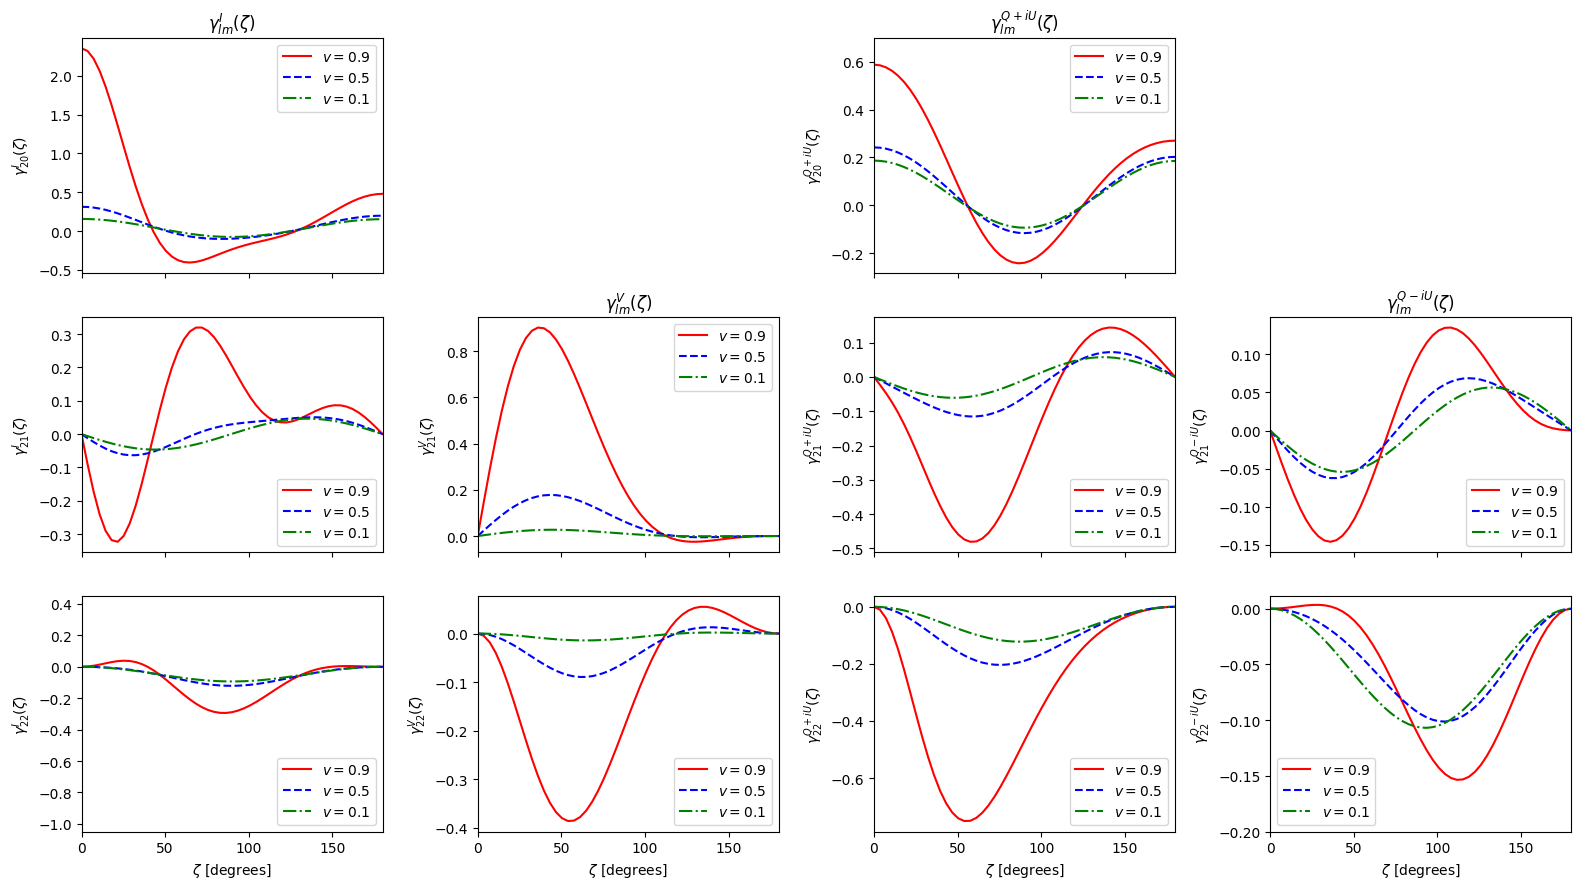

In [15]:
fig, ax = plt.subplots(3, 4, figsize = (16,9))
for xx in ax[:-1, 0]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 1]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 2]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 3]:
    plt.setp(xx.get_xticklabels(), visible=False)
    
ax[0,1].remove()
ax[0,3].remove()

# l = 4, m = 0
ax[0,0].plot(ztarr*180/np.pi, gabV20_v1['I'].real, 'r-', label = r'$v = 0.9$')
ax[0,0].plot(ztarr*180/np.pi, gabV20_v2['I'].real, 'b--', label = r'$v = 0.5$')
ax[0,0].plot(ztarr*180/np.pi, gabV20_v3['I'].real, 'g-.', label = r'$v = 0.1$')
ax[0,0].set_ylabel(r'$\gamma_{20}^I(\zeta)$')
ax[0,0].legend(loc = 'upper right')
ax[0,0].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[0,2].plot(ztarr*180/np.pi, gabV20_v1['QpiU'].real, 'r-', label = r'$v = 0.9$')
ax[0,2].plot(ztarr*180/np.pi, gabV20_v2['QpiU'].real, 'b--', label = r'$v = 0.5$')
ax[0,2].plot(ztarr*180/np.pi, gabV20_v3['QpiU'].real, 'g-.', label = r'$v = 0.1$')
ax[0,2].set_ylabel(r'$\gamma_{20}^{Q + i U}(\zeta)$')
ax[0,2].legend(loc = 'upper right')
ax[0,2].set_xlim(min(ztarr*180/np.pi), max(ztarr*180/np.pi))

ax[2,0].set_xlabel(r'$\zeta$ [degrees]')
ax[2,1].set_xlabel(r'$\zeta$ [degrees]')
ax[2,2].set_xlabel(r'$\zeta$ [degrees]')
ax[2,3].set_xlabel(r'$\zeta$ [degrees]')

ax[0,0].set_title(r'$\gamma_{lm}^I(\zeta)$')
ax[1,1].set_title(r'$\gamma_{lm}^V(\zeta)$')
ax[0,2].set_title(r'$\gamma_{lm}^{Q + iU}(\zeta)$')
ax[1,3].set_title(r'$\gamma_{lm}^{Q - iU}(\zeta)$')

plotIVQU(l = 2, m = 1, zzzz = ztarr, axs = [ax[1,0], ax[1,1], ax[1,2], ax[1,3]], \
         gab = [gabV21_v1, gabV21_v2, gabV21_v3], \
         labels = [r'$v = 0.9$', r'$v = 0.5$', r'$v = 0.1$'], \
         llocs = ['lower right', 'upper right', 'lower right', 'lower right'])
ax[2,0].set_ylim(bottom = -1.05, top = 0.45)

plotIVQU(l = 2, m = 2, zzzz = ztarr, axs = [ax[2,0], ax[2,1], ax[2,2], ax[2,3]], \
         gab = [gabV22_v1, gabV22_v2, gabV22_v3], \
         labels = [r'$v = 0.9$', r'$v = 0.5$', r'$v = 0.1$'], \
         llocs = ['lower right', 'lower right', 'lower right', 'lower left'])
ax[2,3].set_ylim(bottom = -0.20)
ax[0,2].set_ylim(top = 0.7)

fig.tight_layout()
plt.show()

We lastly move to scalar GWs.

### Scalar GWs

The correlation for scalar GWs are setup by the function below. We emphasize that this has no more polarization components and so we are looking only for anisotropies.

In [16]:
def gabAnIs_S(zeta, v, l, m, lM = 10, fD = 1000):
    '''Returns tensor correlation for Stokes I and V'''
    jls = Jls_S(v = v, lM = lM, fD = fD)
    lls = list(jls[:, 0].real) # the indices
    
    dgabdx = []
    # terms
    for l1 in np.arange(0, lM + 1): # sum starts at 0 for scalar modes
        for l2 in np.arange(0, lM + 1):
            
            i1 = lls.index(l1) # indices of l1 and l2 in jls
            i2 = lls.index(l2)
            
            f1 = ((-1)**m)*((2*l1 + 1)/(4*np.pi))*np.sqrt((2*l + 1)*(2*l2 + 1))            
            f2 = w3j(l, l1, l2, 0, 0, 0)*w3j(l, l1, l2, m, 0, -m)             
            f3 = jls[:, 1][i1]*np.conj(jls[:, 1][i2])
            
            if abs(m) <= l2:
                f4 = sph_harm(m, l2, 0, zeta)
            elif abs(m) > l2:
                f4 = 0
            
            dgabdx.append(f1*f2*f3*f4)
            
    return sum(dgabdx)

We test this by comparing the result with PTAfast: version 0 (without anisotropies). The isotropic components $l = m = 0$ from the above calculation and PTAfast should agree.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


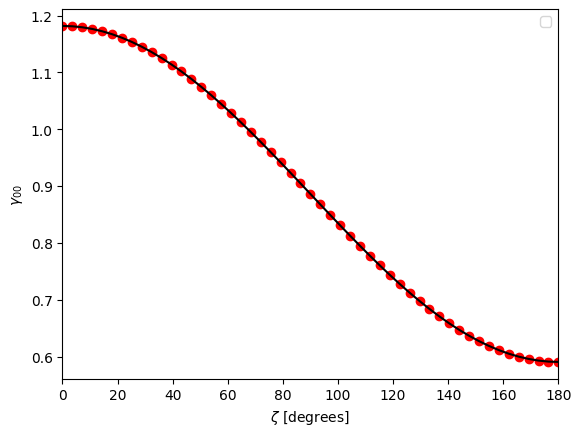

In [17]:
ztarr = np.linspace(0, np.pi, 50 + 1)

# correlations for v = 1.0
gabS00_v1 = gabAnIs_S(ztarr, v = 1.0, l = 0, m = 0, lM = 50)
gabS00_v1_ptafast = ST(lm = 50, v = 1.0, fD = 1000).get_gab(ztarr)

plt.plot(ztarr*180/np.pi, gabS00_v1, 'ro')
plt.plot(ztarr*180/np.pi, gabS00_v1_ptafast, 'k-') # isotropic SGWB from PTAfast_v0

plt.xlabel(r'$\zeta$ [degrees]')
plt.ylabel(r'$\gamma_{00}$')
plt.xlim(0, 180)
plt.legend()
plt.show()

The agreement is reasonable. This is based on the fact that at $v = 1$, only the ST GW mode is able to propagate.

We now make the similar runs to look at the isotropies of the scalar modes.

In [18]:
ztarr = np.linspace(0, np.pi, 200 + 1)

# correlations for v = 1.0
gabS00_v1 = gabAnIs_S(ztarr, v = 1.0, l = 0, m = 0, lM = 50) # isotropic

gabS10_v1 = gabAnIs_S(ztarr, v = 1.0, l = 1, m = 0, lM = 50) # anisotropy
gabS11_v1 = gabAnIs_S(ztarr, v = 1.0, l = 1, m = 1, lM = 50)

gabS20_v1 = gabAnIs_S(ztarr, v = 1.0, l = 2, m = 0, lM = 50)
gabS21_v1 = gabAnIs_S(ztarr, v = 1.0, l = 2, m = 1, lM = 50)
gabS22_v1 = gabAnIs_S(ztarr, v = 1.0, l = 2, m = 2, lM = 50)

gabS30_v1 = gabAnIs_S(ztarr, v = 1.0, l = 3, m = 0, lM = 50)
gabS31_v1 = gabAnIs_S(ztarr, v = 1.0, l = 3, m = 1, lM = 50)
gabS32_v1 = gabAnIs_S(ztarr, v = 1.0, l = 3, m = 2, lM = 50)
gabS33_v1 = gabAnIs_S(ztarr, v = 1.0, l = 3, m = 3, lM = 50)

# correlations for v = 0.5
gabS00_v2 = gabAnIs_S(ztarr, v = 0.5, l = 0, m = 0, lM = 50) # isotropic

gabS10_v2 = gabAnIs_S(ztarr, v = 0.5, l = 1, m = 0, lM = 50) # anisotropy
gabS11_v2 = gabAnIs_S(ztarr, v = 0.5, l = 1, m = 1, lM = 50)

gabS20_v2 = gabAnIs_S(ztarr, v = 0.5, l = 2, m = 0, lM = 50)
gabS21_v2 = gabAnIs_S(ztarr, v = 0.5, l = 2, m = 1, lM = 50)
gabS22_v2 = gabAnIs_S(ztarr, v = 0.5, l = 2, m = 2, lM = 50)

gabS30_v2 = gabAnIs_S(ztarr, v = 0.5, l = 3, m = 0, lM = 50)
gabS31_v2 = gabAnIs_S(ztarr, v = 0.5, l = 3, m = 1, lM = 50)
gabS32_v2 = gabAnIs_S(ztarr, v = 0.5, l = 3, m = 2, lM = 50)
gabS33_v2 = gabAnIs_S(ztarr, v = 0.5, l = 3, m = 3, lM = 50)

# # correlations for v = 0.2
gabS00_v3 = gabAnIs_S(ztarr, v = 0.2, l = 0, m = 0, lM = 50) # isotropic

gabS10_v3 = gabAnIs_S(ztarr, v = 0.2, l = 1, m = 0, lM = 50) # anisotropy
gabS11_v3 = gabAnIs_S(ztarr, v = 0.2, l = 1, m = 1, lM = 50)

gabS20_v3 = gabAnIs_S(ztarr, v = 0.2, l = 2, m = 0, lM = 50)
gabS21_v3 = gabAnIs_S(ztarr, v = 0.2, l = 2, m = 1, lM = 50)
gabS22_v3 = gabAnIs_S(ztarr, v = 0.2, l = 2, m = 2, lM = 50)

gabS30_v3 = gabAnIs_S(ztarr, v = 0.2, l = 3, m = 0, lM = 50)
gabS31_v3 = gabAnIs_S(ztarr, v = 0.2, l = 3, m = 1, lM = 50)
gabS32_v3 = gabAnIs_S(ztarr, v = 0.2, l = 3, m = 2, lM = 50)
gabS33_v3 = gabAnIs_S(ztarr, v = 0.2, l = 3, m = 3, lM = 50)

Below we find the correlation produced by scalar modes at different levels of anisotropy.

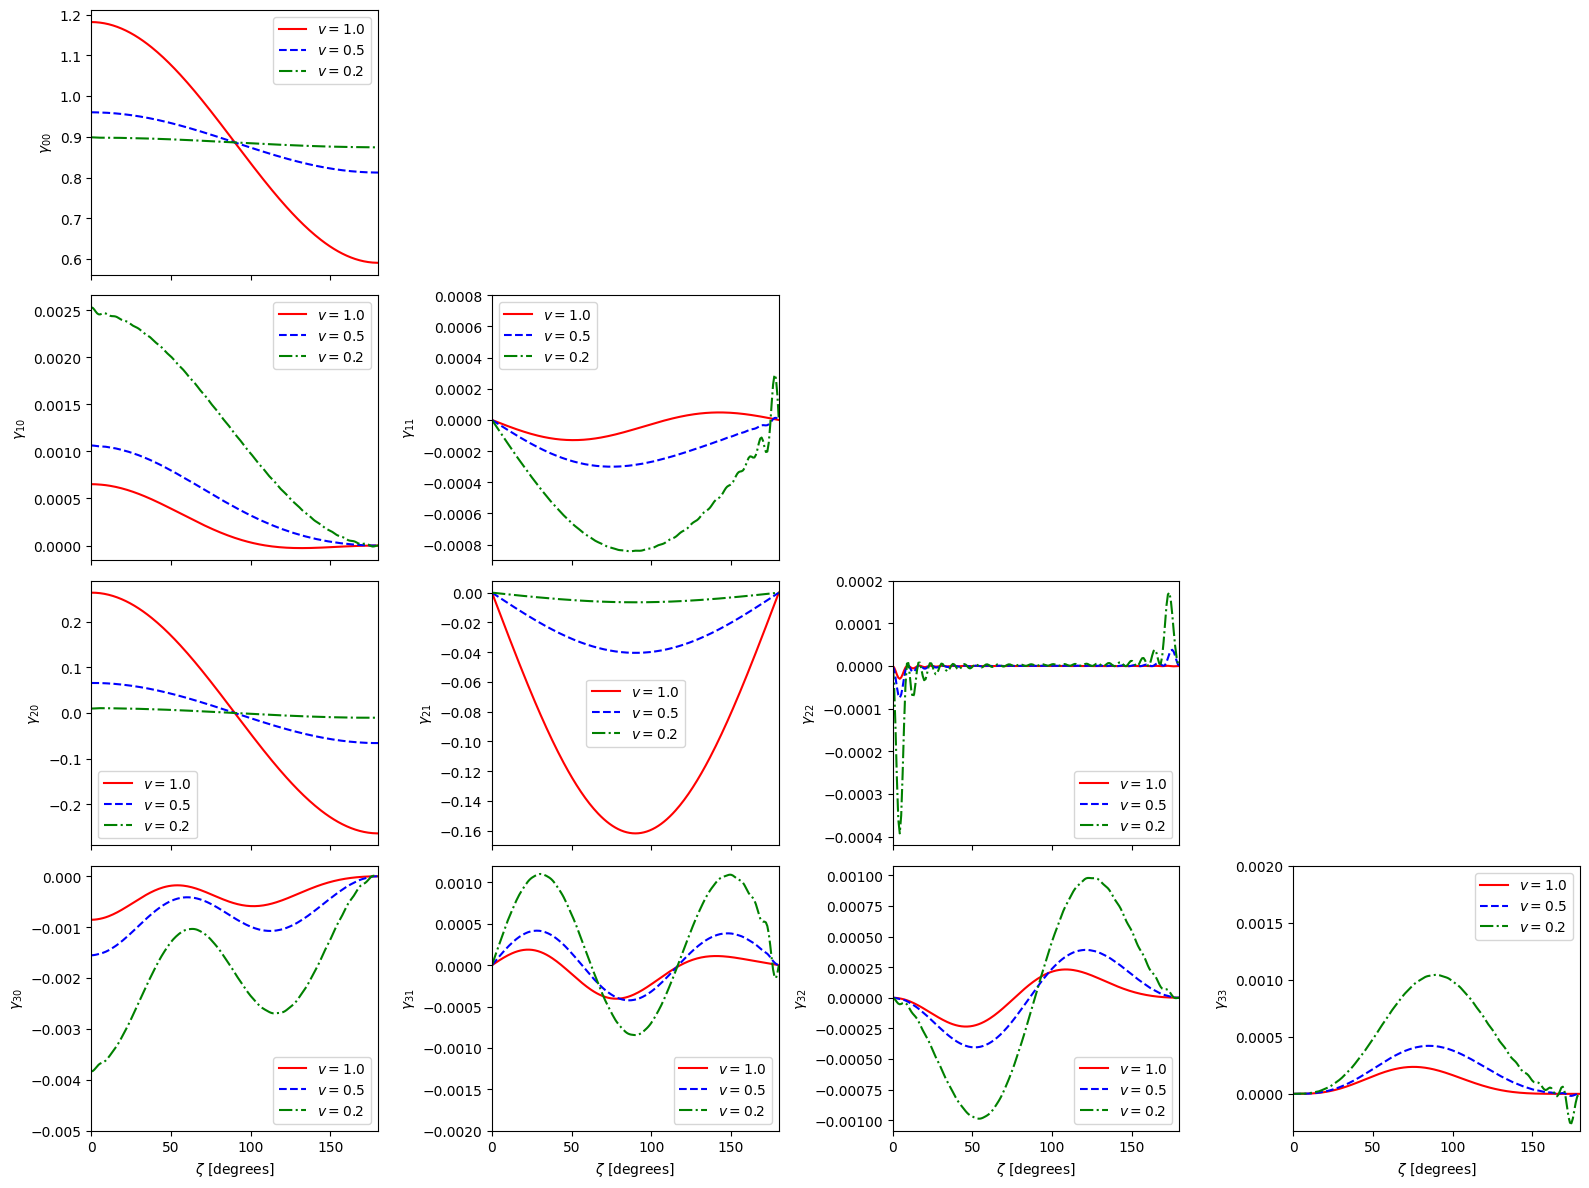

In [19]:
def plotAnis(l, m, zzzz, axx, gab, labels, lloc):
    '''helpful plotting function'''
    axx.plot(zzzz*180/np.pi, gab[0], 'r-', label = labels[0])
    axx.plot(zzzz*180/np.pi, gab[1], 'b--', label = labels[1])
    axx.plot(zzzz*180/np.pi, gab[2], 'g-.', label = labels[2])
    lmstr = str(l) + str(m)
    axx.set_ylabel(r'$\gamma_{' + lmstr + '}$')
    axx.set_xlim(min(zzzz*180/np.pi), max(ztarr*180/np.pi))
    axx.legend(loc = lloc)

fig, ax = plt.subplots(4, 4, figsize = (16,12))
for xx in ax[:-1, 0]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 1]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 2]:
    plt.setp(xx.get_xticklabels(), visible=False)
for xx in ax[:-1, 3]:
    plt.setp(xx.get_xticklabels(), visible=False)
    
ax[0,1].remove()
ax[0,2].remove()
ax[0,3].remove()
ax[1,2].remove()
ax[1,3].remove()
ax[2,3].remove()

plotAnis(l = 0, m = 0, zzzz = ztarr, axx = ax[0,0], \
         gab = [gabS00_v1, gabS00_v2, gabS00_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'upper right')

plotAnis(l = 1, m = 0, zzzz = ztarr, axx = ax[1,0], \
         gab = [gabS10_v1, gabS10_v2, gabS10_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'upper right')

plotAnis(l = 1, m = 1, zzzz = ztarr, axx = ax[1,1], \
         gab = [gabS11_v1, gabS11_v2, gabS11_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'upper left')

plotAnis(l = 2, m = 0, zzzz = ztarr, axx = ax[2,0], \
         gab = [gabS20_v1, gabS20_v2, gabS20_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'lower left')

plotAnis(l = 2, m = 1, zzzz = ztarr, axx = ax[2,1], \
         gab = [gabS21_v1, gabS21_v2, gabS21_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'center')

plotAnis(l = 2, m = 2, zzzz = ztarr, axx = ax[2,2], \
         gab = [gabS22_v1, gabS22_v2, gabS22_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'lower right')

plotAnis(l = 3, m = 0, zzzz = ztarr, axx = ax[3,0], \
         gab = [gabS30_v1, gabS30_v2, gabS30_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'lower right')

plotAnis(l = 3, m = 1, zzzz = ztarr, axx = ax[3,1], \
         gab = [gabS31_v1, gabS31_v2, gabS31_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'lower right')

plotAnis(l = 3, m = 2, zzzz = ztarr, axx = ax[3,2], \
         gab = [gabS32_v1, gabS32_v2, gabS32_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'lower right')

plotAnis(l = 3, m = 3, zzzz = ztarr, axx = ax[3,3], \
         gab = [gabS33_v1, gabS33_v2, gabS33_v3], \
         labels = [r'$v = 1.0$', r'$v = 0.5$', r'$v = 0.2$'], \
         lloc = 'upper right')

ax[1,1].set_ylim(top = 0.0008)
ax[3,0].set_ylim(-0.005)
ax[3,1].set_ylim(-0.002)
ax[3,3].set_ylim(top = 0.002)

ax[3,0].set_xlabel(r'$\zeta$ [degrees]')
ax[3,1].set_xlabel(r'$\zeta$ [degrees]')
ax[3,2].set_xlabel(r'$\zeta$ [degrees]')
ax[3,3].set_xlabel(r'$\zeta$ [degrees]')

fig.tight_layout()
plt.show()

### End of notebook